In [19]:
import geopandas as gpd
import xarray as xr
import pandas as pd
import numpy as np

from scipy.spatial import cKDTree
from shapely.geometry import Point

In [20]:
# Cargamos el dataset de especies. Sirve para definir el área accesible
gdf_occ = gpd.read_file("../data/GeoDataFrame/gdf_species.gpkg").to_crs(4326)


In [21]:
# Construir el área accesible mediante un buffer de 200 km alrededor de las ocurrencias
# "Las especies podrían estar en cualquier lugar dentro de 200 km de donde han sido observadas"

gdf_m = gdf_occ.to_crs(3857)
area_M = gdf_m.buffer(200_000).unary_union  # 200 km
area_M = gpd.GeoSeries([area_M], crs=3857).to_crs(4326)


/tmp/ipykernel_8709/3645815649.py:5: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  area_M = gdf_m.buffer(200_000).unary_union  # 200 km


In [22]:
# Crear una grilla global de puntos cada 0.25 grados

lon = np.arange(-180, 180, 0.25)
lat = np.arange(-90, 90, 0.25)

grid_points = [
    Point(x, y)
    for x in lon
    for y in lat
]

grid = gpd.GeoDataFrame(
    geometry=grid_points,
    crs=4326
)


In [23]:
# Recortar la grilla al área accesible
grid_M = gpd.sjoin(
    grid,
    area_M.to_frame("geometry"),
    how="inner",
    predicate="intersects"
)

grid_M = grid_M.drop(columns="index_right")


In [24]:
len(grid_M)


232368

In [25]:
# Preparar coordenadas
coords = np.column_stack([
    grid_M.geometry.x.values,
    grid_M.geometry.y.values
])


In [ ]:
# Función para muestrear datos netCDF en puntos específicos

def sample_nc_to_points(nc_path, var_name, depth_slice=None):
    ds = xr.open_dataset(nc_path, decode_times=False)
    da = ds[var_name]

    # Profundidad
    if depth_slice and "depth" in da.dims:
        da = da.sel(depth=slice(*depth_slice)).mean("depth")

    # Promediar dimensiones extra
    extra_dims = [
        d for d in da.dims
        if d.lower() not in ["lat","latitude","lon","longitude"]
    ]
    if extra_dims:
        da = da.mean(extra_dims)

    # Detectar dimensiones espaciales
    lat_name = lon_name = None
    for d in da.dims:
        if d.lower() in ["lat","latitude"]:
            lat_name = d
        if d.lower() in ["lon","longitude"]:
            lon_name = d

    if lat_name is None or lon_name is None:
        raise ValueError(f"No lat/lon en {nc_path}")

    lats = da[lat_name].values
    lons = da[lon_name].values

    lon_grid, lat_grid = np.meshgrid(lons, lats)
    values = da.values.flatten()

    tree = cKDTree(
        np.column_stack([lon_grid.flatten(), lat_grid.flatten()])
    )

    _, idx = tree.query(coords, k=1)
    return values[idx]


: 

In [ ]:
# Muestrear variables oceanográficas y agregarlas a la grilla

grid_M["temp"] = sample_nc_to_points(
    "../data/ocean/temperature_celsius.nc",
    "t_an",
    depth_slice=(0, 200)
)

grid_M["salinity"] = sample_nc_to_points(
    "../data/ocean/salinity.nc",
    "s_an",
    depth_slice=(0, 200)
)

grid_M["oxygen"] = sample_nc_to_points(
    "../data/ocean/oxygen_dissolved.nc",
    "o_an",
    depth_slice=(0, 200)
)

grid_M["oxygen_util"] = sample_nc_to_points(
    "../data/ocean/oxygen_utilization.nc",
    "A_an",
    depth_slice=(0, 200)
)

grid_M["nitrate"] = sample_nc_to_points(
    "../data/ocean/nitrate.nc",
    "n_an",
    depth_slice=(0, 200)
)

grid_M["phosphate"] = sample_nc_to_points(
    "../data/ocean/phosphate.nc",
    "p_an",
    depth_slice=(0, 200)
)

grid_M["chl_trend"] = sample_nc_to_points(
    "../data/ocean/chlorophyll.nc",
    "trend"
)


In [ ]:
# Agregar datos de microplásticos mediante un join espacial con el dataset de microplásticos

micro = gpd.read_file("../data/GeoDataFrame/gdf_microplastics.gpkg").to_crs(4326)

grid_M = gpd.sjoin_nearest(
    grid_M,
    micro[["geometry","microplastics_measurement"]],
    how="left",
    distance_col="dist_micro"
)


/usr/local/python/3.12.1/lib/python3.12/site-packages/geopandas/array.py:407: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


In [ ]:
# Limpiar columnas innecesarias

cols_to_drop = [c for c in grid_M.columns if c.startswith("index_")]
grid_M = grid_M.drop(columns=cols_to_drop)


In [ ]:
# Agregar datos de especies mediante un join espacial con el dataset de especies

species = gpd.read_file("../data/GeoDataFrame/gdf_species.gpkg").to_crs(4326)
grid_M = gpd.sjoin_nearest(
    grid_M,
    species[["geometry","sci_name", "redlistCategory"]],
    how="left",
    distance_col="dist_species"
)

/usr/local/python/3.12.1/lib/python3.12/site-packages/geopandas/array.py:407: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


In [ ]:
# Dataset final
features = [
    "temp","salinity","oxygen",
    "nitrate","phosphate",
    "chl_trend","microplastics_measurement", "sci_name", "redlistCategory"
]

grid_ml = grid_M.dropna(subset=features)
len(grid_ml)


155755

In [ ]:
grid_ml

,geometry,temp,salinity,oxygen,oxygen_util,nitrate,phosphate,chl_trend,microplastics_measurement,dist_micro,index_right,sci_name,redlistCategory,dist_species
882,POINT (-179.75 -49.5),8.285769,34.254517,285.344635,4.633673,13.224897,0.980094,1.746829,0.000000,25.025257,65841,Paragorgia arborea,NT,5.055860
887,POINT (-179.75 -48.25),8.720351,34.290123,281.873505,5.563910,12.121664,0.920304,1.809104,0.000000,26.046435,65841,Paragorgia arborea,NT,3.807236
894,POINT (-179.75 -46.5),10.074621,34.428631,272.665710,7.119972,9.487034,0.752345,2.863594,0.003141,27.218880,65841,Paragorgia arborea,NT,2.061966
908,POINT (-179.75 -43),12.744889,34.855434,254.801270,8.345373,5.953496,0.479302,1.250139,0.003141,23.724646,67862,Paragorgia arborea,NT,1.443087
909,POINT (-179.75 -42.75),13.654454,35.019848,249.214890,8.433300,5.189509,0.422229,1.124156,0.003141,23.475124,67862,Paragorgia arborea,NT,1.686713
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1036278,POINT (179.75 -40.5),15.218589,35.282078,239.940720,8.810746,4.693318,0.361250,0.510360,89.000000,1.405297,66814,Paragorgia arborea,NT,1.560236
1036284,POINT (179.75 -39),15.816326,35.369164,238.424316,8.015304,4.656509,0.355681,0.491933,89.000000,1.273601,66814,Paragorgia arborea,NT,1.592745
1036359,POINT (179.75 -20.25),24.510958,35.524223,202.673264,7.069147,0.559547,0.163544,0.859720,0.052411,1.773571,3285,Melanesobasis maculosa,NT,2.532011
1036360,POINT (179.75 -20),24.510958,35.524223,202.673264,7.069147,0.559547,0.163544,1.123910,0.052411,1.524075,3285,Melanesobasis maculosa,NT,2.321493


In [ ]:
grid_ml.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 155755 entries, 882 to 1036361
Data columns (total 14 columns):
 #   Column                     Non-Null Count   Dtype   
---  ------                     --------------   -----   
 0   geometry                   155755 non-null  geometry
 1   temp                       155755 non-null  float32 
 2   salinity                   155755 non-null  float32 
 3   oxygen                     155755 non-null  float32 
 4   oxygen_util                155755 non-null  float32 
 5   nitrate                    155755 non-null  float32 
 6   phosphate                  155755 non-null  float32 
 7   chl_trend                  155755 non-null  float32 
 8   microplastics_measurement  155755 non-null  float64 
 9   dist_micro                 155755 non-null  float64 
 10  index_right                155755 non-null  int64   
 11  sci_name                   155755 non-null  object  
 12  redlistCategory            155755 non-null  object  
 13  dist_spe

In [ ]:
grid_ml_tab = grid_ml.drop(columns="geometry")
grid_ml_tab.to_parquet(
    "../data/grid_ocean/grid_ocean.parquet",
    index=False
)


In [ ]:
grid_ml.to_file(
    "../data/grid_ocean/grid_ocean.gpkg",
    driver="GPKG"
)


In [ ]:
grid_csv = grid_ml.copy()
grid_csv["geometry"] = grid_csv.geometry.to_wkt()
grid_csv.to_csv("../data/grid_ocean/grid_csv.csv", index=False)

/tmp/ipykernel_3084/138859908.py:2: UserWarning: Geometry column does not contain geometry.
  grid_csv["geometry"] = grid_csv.geometry.to_wkt()


# Modelo no supervisado

El clustering es para **identificar perfiles ecológicos** del océano, definidos por condiciones ambientales medias, presiones humanas y dinámicas ambientales, dentro del área accesible

In [1]:
import pandas as pd
import geopandas as gpd
from sklearn.preprocessing import StandardScaler
import hdbscan
import contextily as ctx

from sklearn.cluster import KMeans


In [2]:
df = pd.read_parquet("../data/grid_ocean/grid_ocean.parquet")
df

,temp,salinity,oxygen,oxygen_util,nitrate,phosphate,chl_trend,microplastics_measurement,dist_micro,index_right,sci_name,redlistCategory,dist_species
0,8.285769,34.254517,285.344635,4.633673,13.224897,0.980094,1.746829,0.000000,25.025257,65841,Paragorgia arborea,NT,5.055860
1,8.720351,34.290123,281.873505,5.563910,12.121664,0.920304,1.809104,0.000000,26.046435,65841,Paragorgia arborea,NT,3.807236
2,10.074621,34.428631,272.665710,7.119972,9.487034,0.752345,2.863594,0.003141,27.218880,65841,Paragorgia arborea,NT,2.061966
3,12.744889,34.855434,254.801270,8.345373,5.953496,0.479302,1.250139,0.003141,23.724646,67862,Paragorgia arborea,NT,1.443087
4,13.654454,35.019848,249.214890,8.433300,5.189509,0.422229,1.124156,0.003141,23.475124,67862,Paragorgia arborea,NT,1.686713
...,...,...,...,...,...,...,...,...,...,...,...,...,...
155750,15.218589,35.282078,239.940720,8.810746,4.693318,0.361250,0.510360,89.000000,1.405297,66814,Paragorgia arborea,NT,1.560236
155751,15.816326,35.369164,238.424316,8.015304,4.656509,0.355681,0.491933,89.000000,1.273601,66814,Paragorgia arborea,NT,1.592745
155752,24.510958,35.524223,202.673264,7.069147,0.559547,0.163544,0.859720,0.052411,1.773571,3285,Melanesobasis maculosa,NT,2.532011
155753,24.510958,35.524223,202.673264,7.069147,0.559547,0.163544,1.123910,0.052411,1.524075,3285,Melanesobasis maculosa,NT,2.321493


In [3]:
gdf = gpd.read_file("../data/grid_ocean/grid_ocean.gpkg")

In [4]:
features = [
    "temp","salinity","oxygen",
    "nitrate","phosphate",
    "chl_trend","microplastics_measurement"
]

X = df[features].dropna()

**temp**
- gradiente térmico global
- estructura metabólica y biogeográfica

**salinity**
- masas de agua / estratificación

**oxygen**

- estrés respiratorio / hipoxia

**oxygen_util**

- habitabilidad funcional

**nitrate**

- fertilidad / productividad potencial

**phosphate**

- soporte trófico (complementa nitratos)

**chl_trend**

- dinámica del sistema, no estado
- captura cambio ecológico a largo plazo

**micro_conc**

- presión antropogénica directa
- problema actual creciente

En conjunto: estado + presión + dinámica

In [5]:
# Escalado
X_scaled = StandardScaler().fit_transform(X)

In [6]:
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=1000,
    min_samples=100,
    metric="euclidean"
)

labels = clusterer.fit_predict(X_scaled)

In [7]:
df_clustered = df.loc[X.index].copy()
df_clustered["eco_profile"] = labels

gdf_clustered = gdf.loc[X.index].copy()
gdf_clustered["eco_profile"] = labels

gdf_clustered["eco_profile"].value_counts()

eco_profile
-1     73037
 6     35934
 14    10276
 2      5156
 8      4884
 12     4503
 5      4032
 13     3520
 9      2844
 7      2362
 10     2356
 0      1785
 1      1744
 3      1219
 11     1068
 4      1035
Name: count, dtype: int64

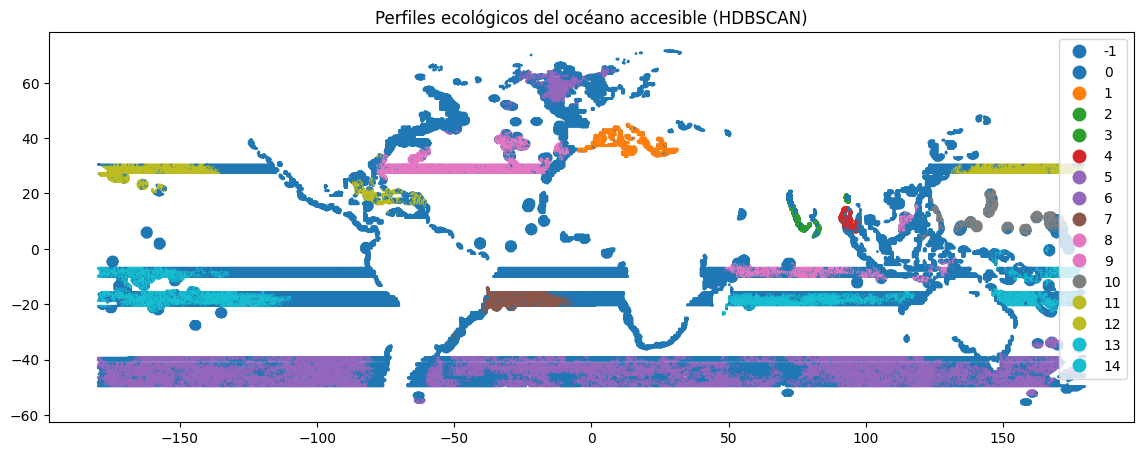

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(14, 6))

gdf_clustered.plot(
    column="eco_profile",
    categorical=True,
    legend=True,
    markersize=1,
    ax=ax
)

ax.set_title("Perfiles ecológicos del océano accesible (HDBSCAN)")
plt.show()


# Interpretar perfiles

In [9]:
profile_summary = (
    df_clustered
    .groupby("eco_profile")[[
        "temp","salinity","oxygen",
        "nitrate","phosphate",
        "chl_trend","microplastics_measurement"
    ]]
    .mean()
)

profile_summary


,temp,salinity,oxygen,nitrate,phosphate,chl_trend,microplastics_measurement
eco_profile,,,,,,,
-1,18.787191,34.751472,212.880203,6.495175,0.626369,0.482976,957.534507
0,26.542980,36.038315,143.789902,3.808969,0.631019,0.021909,19.963486
1,16.629152,38.370533,229.196426,1.515576,0.118296,0.737818,2.924324
2,25.335831,35.214653,122.623306,9.303133,0.928243,0.371506,22.920777
3,25.413275,33.472874,116.125038,12.681330,1.015431,-0.279282,2132.173913
4,25.483133,33.655163,129.412643,9.532682,0.773645,-0.401724,1150.632615
5,10.214384,35.246426,267.372253,8.825143,0.620482,-1.369869,43.483649
6,10.068045,34.425957,275.290344,11.559948,0.933413,1.246877,10.255791
7,23.642584,36.906277,210.417328,0.727201,0.216298,0.393581,10.607082


In [10]:
gdf_plot = gdf_clustered.to_crs(3857)


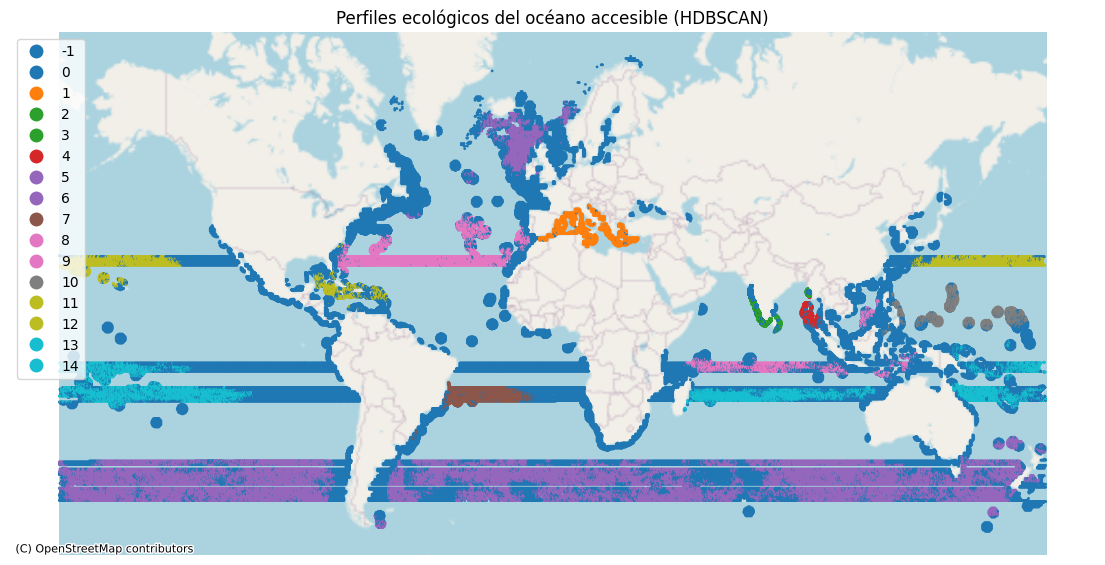

In [11]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(14, 7))

gdf_plot.plot(
    column="eco_profile",
    categorical=True,
    legend=True,
    markersize=1,
    ax=ax
)

ctx.add_basemap(
    ax,
    source=ctx.providers.OpenStreetMap.Mapnik,
    zoom=1
)

ax.set_axis_off()
ax.set_title("Perfiles ecológicos del océano accesible (HDBSCAN)")
plt.show()


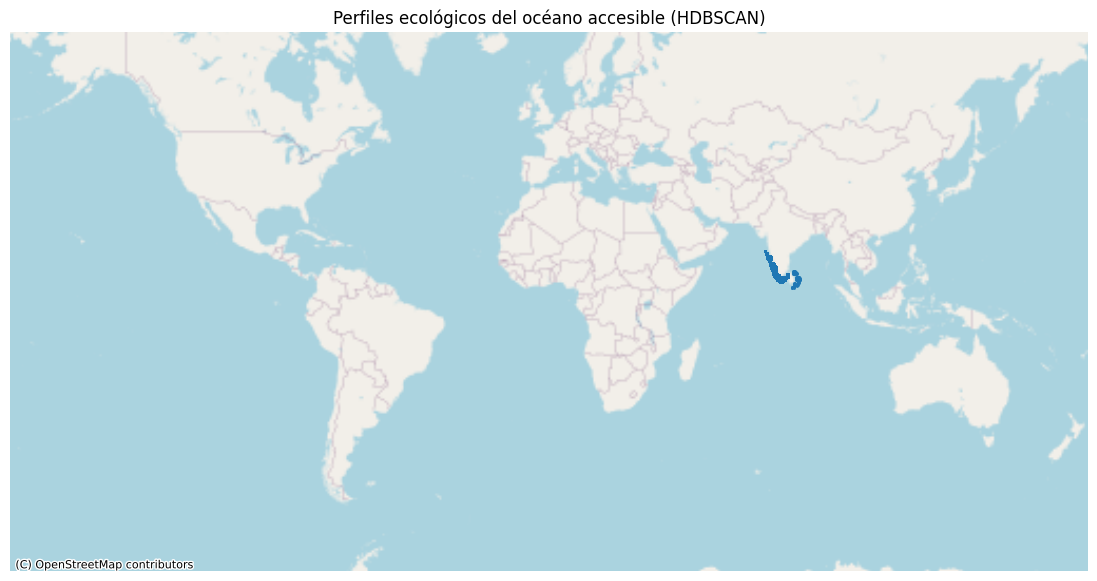

In [12]:
xmin, ymin, xmax, ymax = (-2.0e7, -1.0e7, 2.0e7, 1.0e7)

fig, ax = plt.subplots(1, 1, figsize=(14, 7))

gdf_plot[gdf_plot["eco_profile"] == 2].plot(
    markersize=1,
    ax=ax
)

# FORZAR ESCALA GLOBAL
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

ctx.add_basemap(
    ax,
    source=ctx.providers.OpenStreetMap.Mapnik,
    zoom=1
)
ax.set_axis_off()
ax.set_title("Perfiles ecológicos del océano accesible (HDBSCAN)")
plt.show()

## Prueba con KMeans

In [13]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.9)
X_pca = pca.fit_transform(X_scaled)

print(X_pca.shape)


(155755, 5)


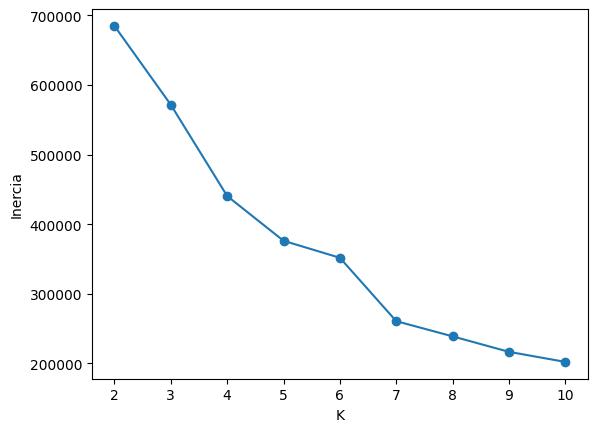

In [14]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
K_range = range(2, 11)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_pca)
    inertia.append(km.inertia_)

plt.plot(K_range, inertia, marker="o")
plt.xlabel("K")
plt.ylabel("Inercia")
plt.show()


In [15]:
kmeans = KMeans(
    n_clusters=6,
    random_state=42,
    n_init=20
)

labels = kmeans.fit_predict(X_pca)

df_clustered["eco_profile_km"] = labels


In [16]:
gdf_clustered["eco_profile_km"] = labels

gdf_clustered["eco_profile_km"].value_counts()

eco_profile_km
1    65099
4    35351
0    29758
2    24926
3      515
5      106
Name: count, dtype: int64

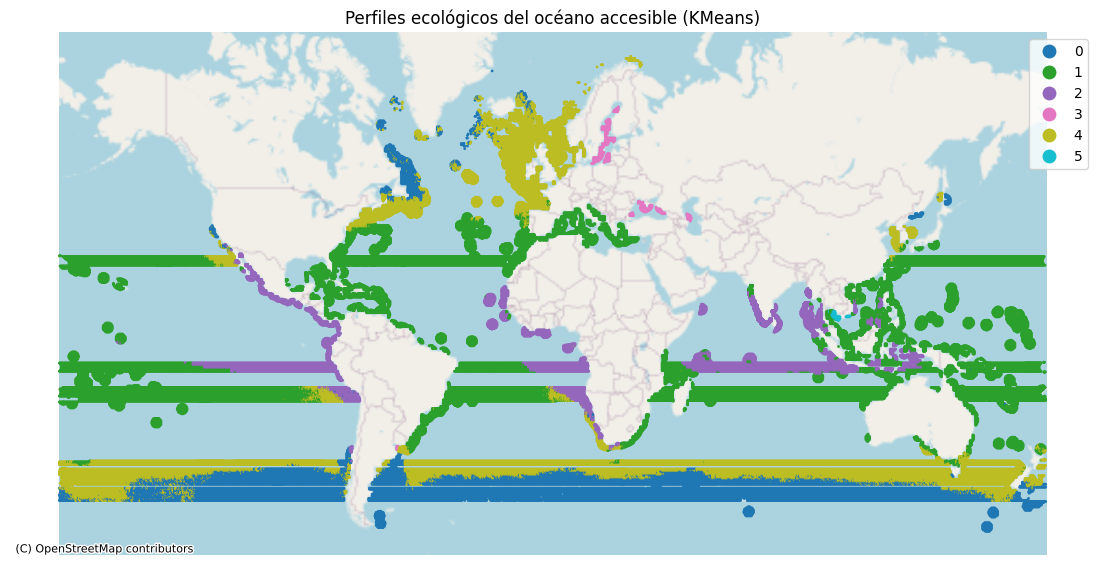

In [17]:
gdf_plot = gdf_clustered.to_crs(3857)
fig, ax = plt.subplots(1, 1, figsize=(14, 7))

gdf_plot.plot(
    column="eco_profile_km",
    categorical=True,
    legend=True,
    markersize=1,
    ax=ax
)

ctx.add_basemap(
    ax,
    source=ctx.providers.OpenStreetMap.Mapnik,
    zoom=1
)

ax.set_axis_off()
ax.set_title("Perfiles ecológicos del océano accesible (KMeans)")
plt.show()

In [18]:
profile_summary_km = (
    df_clustered
    .groupby("eco_profile_km")[[
        "temp","salinity","oxygen",
        "nitrate","phosphate",
        "chl_trend","microplastics_measurement"
    ]]
    .mean()
)

profile_summary_km

,temp,salinity,oxygen,nitrate,phosphate,chl_trend,microplastics_measurement
eco_profile_km,,,,,,,
0,7.807435,34.121620,287.812073,14.908732,1.165049,1.492528,8.815481
1,24.108297,35.560383,202.094742,1.662026,0.254394,0.012338,234.433017
2,23.252022,34.876202,137.732300,9.940257,0.925226,0.046848,803.932509
3,8.013857,12.387325,272.214752,2.313870,0.676344,-0.019589,0.079875
4,11.983054,34.774071,260.664520,7.215979,0.634496,0.719859,12.811805
5,28.394949,32.362072,186.470886,0.605311,0.233856,0.337625,363169.811321


Dataset base: ocurrencias IUCN


In [19]:
gdf_occ_base = gpd.read_file("../data/GeoDataFrame/gdf_species.gpkg").to_crs(4326)
gdf_occ_base.duplicated(subset=["sci_name", "geometry"]).sum()

np.int64(0)

In [20]:
species_lookup = (
    gdf_occ_base[["sci_name"]]
    .drop_duplicates()
    .reset_index(drop=True)
)

species_lookup["species_id"] = range(len(species_lookup))
species_lookup


,sci_name,species_id
0,Hubbsina turneri,0
1,Ictalurus mexicanus,1
2,Ameca splendens,2
3,Lucania interioris,3
4,Notropis aguirrepequenoi,4
...,...,...
1757,Branchipodopsis karroensis,1757
1758,Branchipodopsis barnardi,1758
1759,Branchipodopsis dayae,1759
1760,Parvulastra vivipara,1760


In [21]:
gdf_occ_base = gdf_occ_base.merge(
    species_lookup,
    on="sci_name",
    how="left"
)
gdf_occ_base

,sci_name,presence,origin,seasonal,lon,lat,redlistCategory,geometry,species_id
0,Hubbsina turneri,1,1,1,-101.47950,19.87450,CR,POINT (-101.4795 19.8745),0
1,Hubbsina turneri,1,1,1,-101.77730,19.82560,CR,POINT (-101.7773 19.8256),0
2,Hubbsina turneri,1,1,1,-101.78760,19.82730,CR,POINT (-101.7876 19.8273),0
3,Ictalurus mexicanus,1,1,1,-99.35417,21.98083,VU,POINT (-99.35417 21.98083),1
4,Ictalurus mexicanus,1,1,1,-99.30000,22.00000,VU,POINT (-99.3 22),1
...,...,...,...,...,...,...,...,...,...
70268,Macrobrachium thysi,1,1,1,-3.00185,5.14407,VU,POINT (-3.00185 5.14407),1761
70269,Macrobrachium thysi,1,1,1,-3.52102,5.49955,VU,POINT (-3.52102 5.49955),1761
70270,Macrobrachium thysi,1,1,1,-3.51293,5.49003,VU,POINT (-3.51293 5.49003),1761
70271,Macrobrachium thysi,1,1,1,-4.12282,5.40212,VU,POINT (-4.12282 5.40212),1761


In [22]:
gdf_occ_base["redlistCategory"].value_counts()


redlistCategory
NT    39959
VU    21615
EN     6692
CR     2007
Name: count, dtype: int64

In [23]:
gdf_occ_base["target_threatened"] = (
    gdf_occ_base["redlistCategory"]
    .isin(["VU", "EN", "CR"])
    .astype(int)
)
gdf_occ_base["target_threatened"].value_counts()


target_threatened
0    39959
1    30314
Name: count, dtype: int64

In [24]:
gdf_occ_base.columns


Index(['sci_name', 'presence', 'origin', 'seasonal', 'lon', 'lat',
       'redlistCategory', 'geometry', 'species_id', 'target_threatened'],
      dtype='object')

In [25]:
# 1. Renombrar el ID correcto
gdf_occ_base = gdf_occ_base.rename(
    columns={"species_id_y": "species_id"}
)

# 2. Seleccionar SOLO las columnas finales
gdf_occ_base = gdf_occ_base[
    [
        "species_id",
        "sci_name",
        "redlistCategory",
        "target_threatened",
        "geometry"
    ]
].copy()
gdf_occ_base.head()

,species_id,sci_name,redlistCategory,target_threatened,geometry
0,0,Hubbsina turneri,CR,1,POINT (-101.4795 19.8745)
1,0,Hubbsina turneri,CR,1,POINT (-101.7773 19.8256)
2,0,Hubbsina turneri,CR,1,POINT (-101.7876 19.8273)
3,1,Ictalurus mexicanus,VU,1,POINT (-99.35417 21.98083)
4,1,Ictalurus mexicanus,VU,1,POINT (-99.3 22)


In [26]:
gdf_occ_base.to_file(
    "../data/iucn_occurrences/occurrences_base.gpkg",
    driver="GPKG"
)


In [29]:
gdf_occ_base = gdf_occ_base.to_crs(4326)
gdf_clustered =gdf_clustered.to_crs(4326)

In [36]:
gdf_occ_proj = gpd.sjoin_nearest(
    gdf_occ_base,
    gdf_clustered[["eco_profile_km", "eco_profile", "geometry"]],
    how="left",
    distance_col="dist_to_grid"
)
gdf_occ_proj

/usr/local/python/3.12.1/lib/python3.12/site-packages/geopandas/array.py:407: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


,species_id,sci_name,redlistCategory,target_threatened,geometry,index_right,eco_profile_km,eco_profile,dist_to_grid
0,0,Hubbsina turneri,CR,1,POINT (-101.4795 19.8745),28459,2,-1,2.134285
1,0,Hubbsina turneri,CR,1,POINT (-101.7773 19.8256),28459,2,-1,1.963444
2,0,Hubbsina turneri,CR,1,POINT (-101.7876 19.8273),28459,2,-1,1.961260
3,1,Ictalurus mexicanus,VU,1,POINT (-99.35417 21.98083),30564,1,-1,2.369508
3,1,Ictalurus mexicanus,VU,1,POINT (-99.35417 21.98083),30563,1,-1,2.369508
...,...,...,...,...,...,...,...,...,...
70268,1761,Macrobrachium thysi,VU,1,POINT (-3.00185 5.14407),76240,2,-1,0.144082
70269,1761,Macrobrachium thysi,VU,1,POINT (-3.52102 5.49955),76026,2,-1,0.499992
70270,1761,Macrobrachium thysi,VU,1,POINT (-3.51293 5.49003),76026,2,-1,0.490201
70271,1761,Macrobrachium thysi,VU,1,POINT (-4.12282 5.40212),75803,2,-1,0.420458


In [40]:
dup = gdf_occ_proj.duplicated(
    subset=["species_id", "geometry"],
    keep=False
)

dup.sum()


np.int64(49637)

In [44]:
len(gdf_occ_base), len(gdf_occ_proj)


(70273, 113066)

In [45]:
gdf_occ_proj = (
    gdf_occ_proj
    .sort_values("dist_to_grid")
    .drop_duplicates(
        subset=["species_id", "geometry"],
        keep="first"
    )
)



In [46]:
len(gdf_occ_proj)


70273

In [47]:
gdf_occ_proj["eco_profile_km"].isna().mean()


np.float64(0.0)

In [48]:
gdf_occ_proj["dist_to_grid"].describe()






count    70273.000000
mean         1.610373
std          2.316788
min          0.000000
25%          0.371025
50%          1.116071
75%          1.908987
max         37.508104
Name: dist_to_grid, dtype: float64

In [49]:
gdf_occ_proj = gdf_occ_proj.rename(
    columns={"eco_profile": "eco_profile_hdb"}
)
gdf_occ_proj = gdf_occ_proj[
    [
        "species_id",
        "sci_name",
        "redlistCategory",
        "target_threatened",
        "eco_profile_km",
        "eco_profile_hdb",
        "geometry"
    ]
].copy()


In [50]:
gdf_occ_proj.to_file(
    "../data/iucn_occurrences/occurrences_with_profiles.gpkg",
    driver="GPKG"
)


In [52]:
counts = (
    gdf_occ_proj
    .groupby(["species_id", "eco_profile_km"])
    .size()
    .reset_index(name="n")
)
counts

,species_id,eco_profile_km,n
0,0,2,3
1,1,1,2
2,2,2,10
3,3,1,2
4,3,2,8
...,...,...,...
2040,1757,2,2
2041,1758,1,3
2042,1759,2,2
2043,1760,4,104


In [54]:
counts["prop"] = (
    counts["n"] /
    counts.groupby("species_id")["n"].transform("sum")
)
counts

,species_id,eco_profile_km,n,prop
0,0,2,3,1.0
1,1,1,2,1.0
2,2,2,10,1.0
3,3,1,2,0.2
4,3,2,8,0.8
...,...,...,...,...
2040,1757,2,2,1.0
2041,1758,1,3,1.0
2042,1759,2,2,1.0
2043,1760,4,104,1.0


In [57]:
features = (
    counts
    .pivot(
        index="species_id",
        columns="eco_profile_km",
        values="prop"
    )
    .fillna(0)
)

features.columns = [f"prop_km_{c}" for c in features.columns]


features

,prop_km_0,prop_km_1,prop_km_2,prop_km_3,prop_km_4,prop_km_5
species_id,,,,,,
0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.2,0.8,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
1757,0.0,0.0,1.0,0.0,0.0,0.0
1758,0.0,1.0,0.0,0.0,0.0,0.0
1759,0.0,0.0,1.0,0.0,0.0,0.0


In [59]:
targets = (
    gdf_occ_proj
    .drop_duplicates("species_id")
    .set_index("species_id")[["redlistCategory", "target_threatened"]]
)
targets


,redlistCategory,target_threatened
species_id,,
1738,NT,0
824,VU,1
1737,NT,0
1736,NT,0
309,VU,1
...,...,...
1017,NT,0
400,VU,1
1325,VU,1


In [61]:
df_supervised = features.join(targets)
df_supervised


,prop_km_0,prop_km_1,prop_km_2,prop_km_3,prop_km_4,prop_km_5,redlistCategory,target_threatened
species_id,,,,,,,,
0,0.0,0.0,1.0,0.0,0.0,0.0,CR,1
1,0.0,1.0,0.0,0.0,0.0,0.0,VU,1
2,0.0,0.0,1.0,0.0,0.0,0.0,CR,1
3,0.0,0.2,0.8,0.0,0.0,0.0,EN,1
4,0.0,1.0,0.0,0.0,0.0,0.0,VU,1
...,...,...,...,...,...,...,...,...
1757,0.0,0.0,1.0,0.0,0.0,0.0,EN,1
1758,0.0,1.0,0.0,0.0,0.0,0.0,NT,0
1759,0.0,0.0,1.0,0.0,0.0,0.0,EN,1


In [63]:
df_supervised.to_parquet(
    "../data/iucn_occurrences/species_supervised.parquet",
    index=True
)
